In [1]:
import random 
import numpy as np 
from deap import algorithms 
from deap import base 
from deap import creator
from deap import tools

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

In [2]:
import string 

seed = 222
TARGET = "LEARNING GENETIC ALGORITHMS IS FUN"
CHARSET = string.ascii_uppercase + " " 


In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # maximizing the number of correct letters
creator.create("Individual", list, fitness=creator.FitnessMax) 

In [4]:
def fitness(individual): 
  return sum(1 for i, c in enumerate(individual) if c == TARGET[i]),

def string_mutate(individual): 
  for i in range(len(individual)):
    if random.random() < 0.1: 
      individual[i] = random.choice(CHARSET)
  return individual,

In [5]:
toolbox = base.Toolbox()

# Generate a random character
toolbox.register("random_char", random.choice, CHARSET) 

# Generate an individual (a list of characters forming a string) 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.random_char, len(TARGET))

# Generate a population of individuals 
toolbox.register("population", tools.initRepeat, list, toolbox.individual) 

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", string_mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

In [6]:
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=__debug__):
    pop_per_gen = []  # To store populations at each generation
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    pop_per_gen.append(population[:])  # Store initial population

    # Begin the evolution
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        # offspring = list(map(toolbox.clone, offspring))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        best_individual = "".join(max(population, key=lambda ind: ind.fitness.values[0]))
        if best_individual == TARGET:
            print(f"✅ Found exact match: {best_individual}\n")
            if halloffame is not None:
                halloffame.update(population)  # Ensure best individual is stored
            break  # Stop the


        if halloffame is not None:
            halloffame.update(population)

        # Replace the old population with the offspring
        population[:] = offspring
        
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        pop_per_gen.append(population[:])  # Store snapshot of population at this generation

    return population, logbook, pop_per_gen

gen	nevals
0  	100   
1  	66    
2  	73    
3  	74    
4  	60    
5  	74    
6  	72    
7  	74    
8  	70    
9  	58    
10 	66    
11 	64    
12 	69    
13 	62    
14 	64    
15 	70    
16 	68    
17 	66    
18 	64    
19 	71    
20 	66    
21 	58    
22 	80    
23 	70    
24 	59    
25 	74    
26 	70    
27 	74    
28 	66    
29 	60    
30 	72    
31 	77    
32 	84    
33 	72    
34 	66    
35 	74    
36 	60    
37 	68    
38 	82    
39 	73    
40 	58    
41 	66    
42 	64    
43 	69    
44 	72    
45 	74    
46 	75    
47 	70    
48 	76    
49 	84    
50 	68    
51 	71    
52 	71    
53 	70    
54 	57    
55 	76    
56 	62    
57 	65    
58 	68    
59 	68    
60 	72    
61 	76    
62 	74    
63 	64    
64 	70    
65 	71    
66 	76    
67 	68    
68 	78    
69 	64    
70 	71    
71 	52    
72 	76    
73 	75    
74 	70    
75 	74    
76 	59    
77 	80    
78 	57    
79 	64    
80 	84    
81 	79    
82 	70    
83 	66    
84 	65    
85 	70    
86 	68    
87 	76    
88 	65    
89 	67    

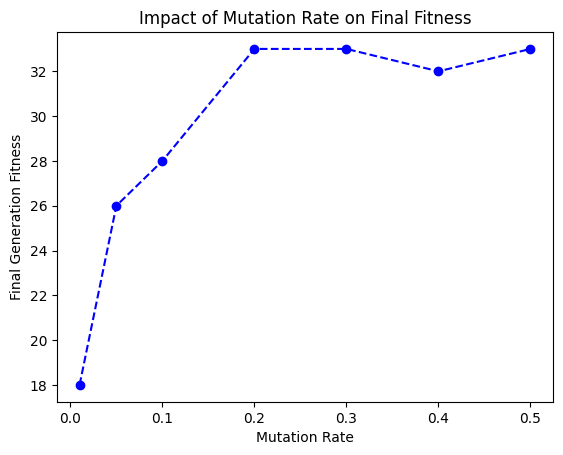

In [7]:
random.seed(seed)

mutation_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
final_fitness = []

for rate in mutation_rates:
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    population, logbook, _ = eaSimple(population=pop, 
                        toolbox=toolbox, 
                        cxpb=0.7, 
                        mutpb=rate,
                        ngen=200, 
                        # stats=stats, 
                        halloffame=hof,
                        verbose=True) 
    best_fitness = hof[0].fitness.values[0]
    final_fitness.append(best_fitness)

plt.plot(mutation_rates, final_fitness, marker="o", linestyle="--", color="b")
plt.xlabel("Mutation Rate")
plt.ylabel("Final Generation Fitness")
plt.title("Impact of Mutation Rate on Final Fitness")
plt.show()

In [8]:
random.seed(seed)

pop = toolbox.population(n=100)
hof = tools.HallOfFame(1) 

stats = tools.Statistics(lambda ind: ind.fitness.values) 
stats.register("avg", lambda vals: np.mean([v[0] for v in vals]))
stats.register("std", lambda vals: np.std([v[0] for v in vals]))
stats.register("min", lambda vals: min(v[0] for v in vals))
stats.register("max", lambda vals: max(v[0] for v in vals)) 

population, logbook, pop_per_gen = eaSimple(population=pop, 
                        toolbox=toolbox, 
                        cxpb=0.7, 
                        mutpb=0.5,
                        ngen=200, 
                        stats=stats, 
                        halloffame=hof,
                        verbose=True)

best = hof[0] 
print(f"Hall of Fame (HOF) Best Individual:  {''.join(best)}")
print(f"Hall of Fame Fitness: {hof[0].fitness.values}")


gen	nevals	avg 	std    	min	max
0  	100   	1.08	1.13737	0  	5  
1  	82    	1.83	1.06822	0  	5  
2  	84    	2.72	1.0008 	0  	6  
3  	87    	3.38	1.05622	1  	6  
4  	84    	3.92	1.16344	1  	6  
5  	91    	4.77	1.02815	2  	7  
6  	86    	5.45	1.01366	3  	8  
7  	85    	5.88	1.20233	2  	9  
8  	87    	6.54	0.9531 	4  	9  
9  	87    	6.9 	1.11803	4  	10 
10 	91    	7.58	1.17627	5  	10 
11 	86    	8.1 	1.38924	5  	13 
12 	84    	9.01	1.41771	5  	12 
13 	88    	9.5 	1.38203	6  	13 
14 	86    	10.23	1.57388	6  	14 
15 	93    	10.96	1.43471	6  	14 
16 	85    	11.61	1.30303	8  	15 
17 	88    	12.17	1.30426	8  	15 
18 	83    	12.83	1.46325	9  	16 
19 	86    	13.37	1.31647	9  	16 
20 	91    	13.96	1.60574	9  	17 
21 	85    	14.77	1.18199	12 	17 
22 	85    	14.87	1.58528	10 	19 
23 	86    	15.14	1.74367	9  	19 
24 	80    	15.68	1.60549	11 	19 
25 	87    	15.84	1.55383	11 	19 
26 	80    	16.41	1.55625	13 	19 
27 	92    	16.78	1.50718	13 	20 
28 	91    	16.86	1.8167 	12 	20 
29 	71    	17.66	1.60761	

#### Evaluations

##### Fitness Progression Over Generations

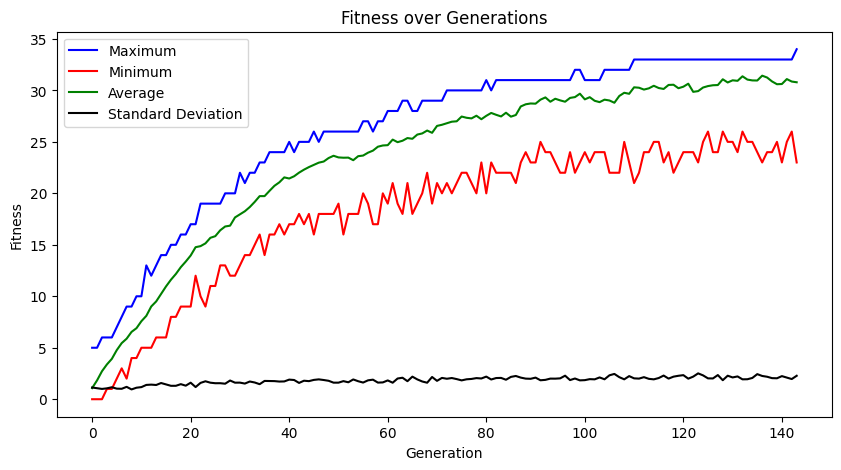

In [9]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 5)) 
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_avgs = logbook.select("avg")
fit_stds = logbook.select("std")  

plt.plot(gen, fit_maxs, "b-", label="Maximum")
plt.plot(gen, fit_mins, "r-", label="Minimum")
plt.plot(gen, fit_avgs, "g-", label="Average")
plt.plot(gen, fit_stds, "k-", label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.title("Fitness over Generations")
plt.show()

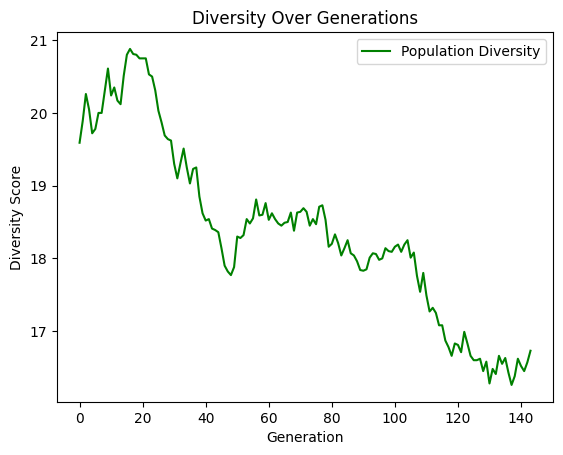

In [10]:
import numpy as np

def compute_diversity(population):
    """Returns the average number of unique characters across all individuals."""
    unique_counts = [len(set(ind)) for ind in population]
    return np.mean(unique_counts)

diversity_scores = [compute_diversity(pop) for pop in pop_per_gen]

plt.plot(gen, diversity_scores, label="Population Diversity", color='g')
plt.xlabel("Generation")
plt.ylabel("Diversity Score")
plt.title("Diversity Over Generations")
plt.legend()
plt.show()